# Timeseries Analysis 1 
## Simple Forecasting

In this first notebook, I am going to investigate the simplest timeseries forecasting methods. To understand their performances, I am going to investigate it using highly seasonal data, with a clear trend (CO$_2$ data collected at manua loa) and much less ordered data (the DOWJ index). 

All the methods are written in a seperate notebook for cleanliness, called `timeseries.py`.

## 0. Setup

### 0.1. Importing modules

In [36]:
% matplotlib inline

import timeseries; reload(timeseries)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### 0.2. Importing data

The data has been taken from R.J. Hyndman's time series database on [datamarket](https://datamarket.com/data/set/22v1/co2-ppm-mauna-loa-1965-1980#!ds=22v1&display=line)

In [6]:
co2 = pd.read_csv("co2-ppm-mauna-loa-19651980.csv")
DOWJ = pd.read_csv("weekly-closings-of-the-dowjones-.csv")

## Some cleaning 

# the last row just repeats the header, so I remove it
co2 = co2[:-1]
DOWJ = DOWJ[:-1]

# next, I get the numpy arrays from the dataframes
co2 = co2["CO2 (ppm) mauna loa, 1965-1980"].as_matrix()
DOWJ = DOWJ["Weekly closings of the Dow-Jones industrial average, July 1971 ? August 1974"].as_matrix()

# finally, I turn the values from strings into floats
co2 = [float(x) for x in co2]
DOWJ = [float(x) for x in DOWJ]

Plots, to make sure it is okay

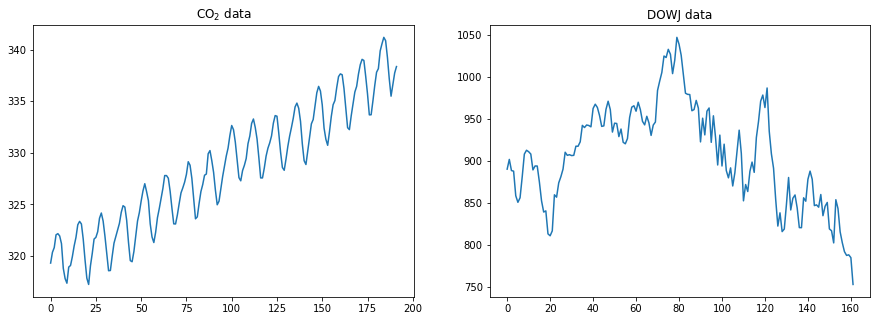

In [16]:
f, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(co2)
ax[0].set_title("CO$_2$ data")
ax[1].plot(DOWJ)
ax[1].set_title("DOWJ data")

### 0.3 Defining a mean squared error function

This will allow the performance of different techniques to be (roughly) quantified

In [17]:
def mse(true_values, predicted_values):
    
    error = [(true_value - predicted_value)**2 for true_value, predicted_value 
                 in zip(true_values, predicted_values)]
    error = [value for value in error if (np.isnan(value)==False)]
    return sum(error)/len(true_values)

### 0.4 Defining easy plotting functions

#### 0.4.1. Plotting one calculated array

In [38]:
def side_by_side_plots(org_data1, new_data1, org_data2, new_data2, new_data_type, data1_type, data2_type):
    f, ax = plt.subplots(1,2, figsize = (15,5))
    plt.suptitle(new_data_type)
    ax[0].plot(org_data1, label = 'Original Data')
    ax[0].plot(new_data1, label = new_data_type)
    ax[0].legend()
    ax[0].set_title(data1_type + " data - MSE = " + str(mse(org_data1, new_data1)))
    ax[1].plot(org_data2, label = 'Original Data')
    ax[1].plot(new_data2, label = new_data_type)
    ax[1].legend()
    ax[1].set_title(data2_type +" data - MSE = " + str(mse(org_data2, new_data2)))


#### 0.4.2 Plotting lots of calculated arrays

In [53]:
def many_side_by_side_plots(org_data1, new_data1, org_data2, new_data2, new_data_type, data1_type, data2_type, 
                            differentiator, differentiator_type):
    f, ax = plt.subplots(1,2, figsize = (15,5))
    plt.suptitle(new_data_type)
    ax[0].plot(org_data1, label = 'Original Data')
    for i in range(len(new_data1)):
        ax[0].plot(new_data1[i], label = differentiator_type + ": " + str(differentiator[i])
                   + ", MSE: " + str("{0:.2f}".format(mse(org_data1, new_data1[i]))))
    ax[0].legend()
    ax[0].set_title(data1_type + " data")
    ax[1].plot(org_data2, label = 'Original Data')
    for i in range(len(new_data2)):
        ax[1].plot(new_data2[i], label = differentiator_type + ": " + str(differentiator[i])
                    + ", MSE: " + str("{0:.2f}".format(mse(org_data2, new_data2[i]))))
    ax[1].legend()
    ax[1].set_title(data2_type +" data")


## 1. Averaging and Smoothing techniques

These are the simplest time series analysis, which only consider the averages of the data. 

### 1.1. Average

In [18]:
co2_average = timeseries.simple_average(co2)
DOWJ_average = timeseries.simple_average(DOWJ)

/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


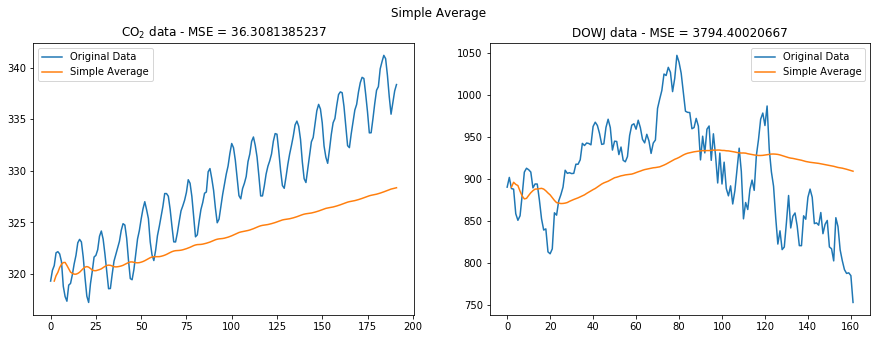

In [39]:
side_by_side_plots(co2, co2_average, DOWJ, DOWJ_average, 'Simple Average', 'CO$_2$', 'DOWJ')

### 1.2. Moving Average

A problem with the simple average is that it gets 'weighed down' by old values, which are not relevant to calculating the trend. 

One way to get around this is to only calculate the average from a 'window' of previous values. 

In [33]:
# this can be changed
window_size = [8, 12, 16]

In [37]:
co2_moving_average = timeseries.moving_average(co2, window_size)
DOWJ_moving_average = timeseries.moving_average(DOWJ, window_size)

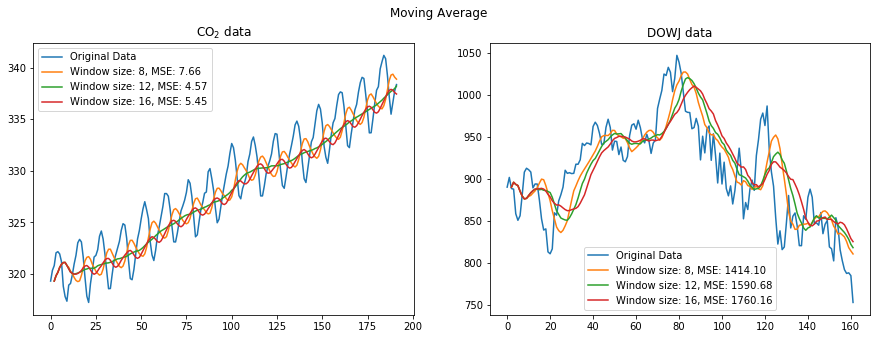

In [55]:
many_side_by_side_plots(co2, co2_moving_average, DOWJ, DOWJ_moving_average,'Moving Average', 'CO$_2$', 'DOWJ', 
                            window_size, "Window size")

## 1.3. Single Value Exponential


Although it acknowledges the problem, the moving window average still faces the same flaw as the total average; older values are likely to be less relevant than newer values. 

Exponential smoothing assigns an exponentially decreasing weight to values, ensuring that values closer to the time fo prediction will be more heavily weighted than those further away. 

In [56]:
alphas = [0.3, 0.6, 0.9]

In [57]:
co2_exponential_smoothing = timeseries.single_value_exponential_smoothing_1(co2, alphas)
DOWJ_exponential_smoothing = timeseries.single_value_exponential_smoothing_1(DOWJ, alphas)

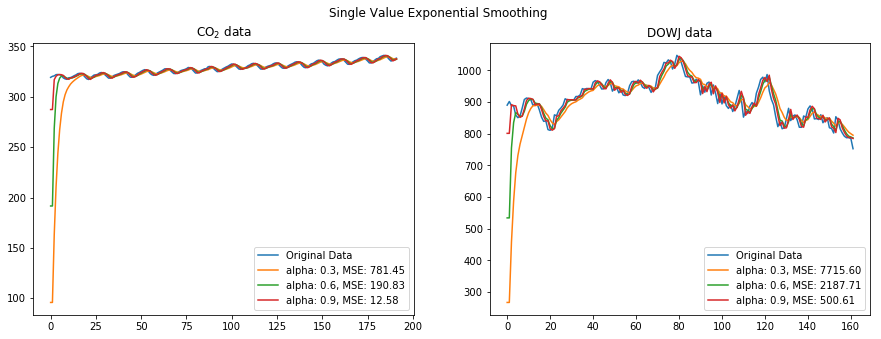

In [61]:
many_side_by_side_plots(co2, co2_exponential_smoothing, DOWJ, DOWJ_exponential_smoothing,
                        'Single Value Exponential Smoothing', 'CO$_2$', 'DOWJ', 
                            alphas, "alpha")

Ignoring the beginning, when there is clearly not enough data to make a successful prediction: 

In [64]:
truncated_co2 = [x[25:] for x in co2_exponential_smoothing]
truncated_DOWJ = [x[20:] for x in DOWJ_exponential_smoothing]

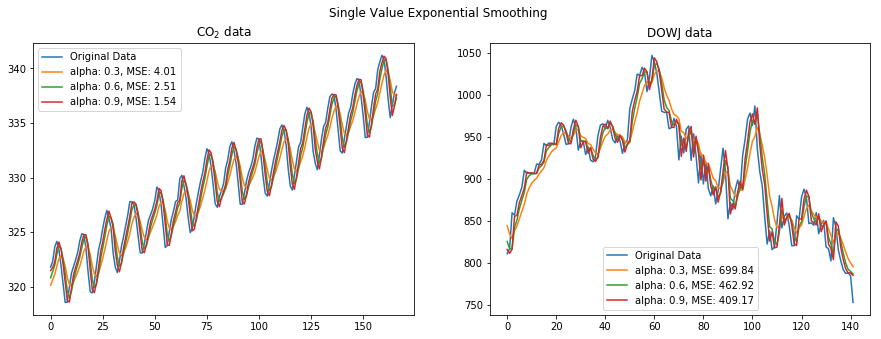

In [65]:
many_side_by_side_plots(co2[25:], truncated_co2, DOWJ[20:], truncated_DOWJ,
                        'Single Value Exponential Smoothing', 'CO$_2$', 'DOWJ', 
                            alphas, "alpha")